In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from sklearn.metrics import explained_variance_score
from models.gru import GRU
import scipy

# Train

In [2]:
class AP_GRU_Lag(nn.Module):
    def __init__(self, H_no, lag, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        
        self.rnn = nn.GRU(lag+1, H_no, batch_first=True)
        self.linear = nn.Linear(H_no, 1)
        
    def forward(self, V):
        #V is shape (batch, 50000, lag+1)

        rnn_out, _ = self.rnn(V) #(batch,50000,H)
        rnn_out = rnn_out.reshape(-1,self.H_no)
        lin_out = self.linear(rnn_out).reshape(V.shape[0], V.shape[1]) #(batch*50000,1)
        
        return lin_out



In [3]:
T_train = 980 * 1000 * 50
T_test = 1 * 1000 * 50
batch_size = 5
batch_length = 50000
H_casc = 20
H_out = 40
device = torch.device("cuda:0")
iter_no = 9800*2
epoch_no = iter_no*batch_length*batch_size//T_train
lag = 20
E_no = 2000
I_no = 200
sub_no = 5

In [4]:
base_dir = "/scratch/yjk27/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
#S = np.load("/scratch/yjk27/CA1_clust4-60_AP/data/spike_train_0.2ms.npy").flatten()
#S = torch.from_numpy(S)
V = np.load("/scratch/yjk27/CA1_clust4-60_AP/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy")[:,:50000].flatten()
V_mean = np.mean(np.load("/scratch/yjk27/CA1_clust4-60/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1_set1.npy"))
V -= V_mean
print(V_mean)
V = torch.from_numpy(V)

soma_mean = np.mean(np.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/V_comb_pred_0.2ms.npy"))
soma_mean = float(soma_mean)
print(soma_mean)

C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/handsub5_C_syn_e.npy")
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/handsub5_C_syn_i.npy")
C_syn_e = torch.from_numpy(C_syn_e).float()
C_syn_i = torch.from_numpy(C_syn_i).float()

-65.29324819311567
0.012945710862632371


In [5]:
V_train = V[:T_train].float()
V_test = V[-50000:].to(device).float()

test_E_neural = E_neural[-50000:].toarray()
test_I_neural = I_neural[-50000:].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]
test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model_na = GRU(C_syn_e.to(device), C_syn_i.to(device), H_casc, device)
model_nona = GRU(C_syn_e.to(device), C_syn_i.to(device), H_casc, device)
model_ap = AP_GRU_Lag(H_out, lag, device)

optimizer_na = torch.optim.Adam(model_na.parameters(), lr = 0.0001)
optimizer_nona = torch.optim.Adam(model_nona.parameters(), lr = 0.0001)
optimizer_ap = torch.optim.Adam(model_ap.parameters(), lr = 0.0001)
model_na.to(device).float()
model_nona.to(device).float()
model_ap.to(device).float()

bce_criterion = nn.BCELoss(reduction="mean")

In [7]:
model_na.load_state_dict(torch.load("/scratch/yjk27/CA1_clust4-60/mono/gru_s5_h20.pt",
                     map_location=device))
model_nona.load_state_dict(torch.load("/scratch/yjk27/CA1_clust4-60_noNA/mono/gru_s5_h20.pt",
                     map_location=device))
model_ap.load_state_dict(torch.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_l20_h40_0.2ms_V.pt",
                     map_location=device))

<All keys matched successfully>

In [8]:
score_list = np.zeros((iter_no//50))

for i in tnrange(iter_no):
    s = time.time()
    
    model_na.train()
    model_nona.train()
    model_ap.train()
    optimizer_na.zero_grad()
    optimizer_nona.zero_grad()
    optimizer_ap.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    batch_na, _ = model_na(batch_E_neural, batch_I_neural)
    batch_nona, _ = model_nona(batch_E_neural, batch_I_neural)
    
    batch_soma = batch_na + batch_nona - soma_mean
    batch_soma_in = torch.zeros((batch_size, batch_length, lag+1)).to(device) #(lag,1000,50000)
    for j in range(lag):
        batch_soma_in[:,j+1:,j+1] = batch_soma_in[:,j+1:,j+1] + batch_soma[:,:-j-1]
    batch_soma_in[:,:,0] = batch_soma_in[:,:,0] + batch_soma 
    
    V_out = model_ap(batch_soma_in) + batch_soma
    loss = torch.mean((V_out - batch_V) ** 2)
    #loss = bce_criterion(S_out, batch_S)

    loss.backward()
    nn.utils.clip_grad_norm_(model_na.parameters(), 1)
    nn.utils.clip_grad_norm_(model_nona.parameters(), 1)
    nn.utils.clip_grad_norm_(model_ap.parameters(), 1)
    optimizer_na.step()
    optimizer_nona.step()
    optimizer_ap.step()
    s1 = time.time()
    
    if (i%50 == 49) or (i == 0):
        model_na.eval()
        model_nona.eval()
        model_ap.eval()

        test_na, _ = model_na(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0))
        test_nona, _ = model_nona(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0))
        
        test_soma = test_na + test_nona - soma_mean
        test_soma_in = torch.zeros((1, batch_length, lag+1)).to(device) #(lag,1000,50000)
        for j in range(lag):
            test_soma_in[:,j+1:,j+1] = test_soma_in[:,j+1:,j+1] + test_soma[:,:-j-1]
        test_soma_in[:,:,0] = test_soma_in[:,:,0] + test_soma
        
        test_V_out = model_ap(test_soma_in).flatten() + test_soma.flatten()
        test_loss = torch.mean((test_V_out - V_test)**2).cpu().detach().numpy()
        #test_loss = bce_criterion(test_S_out, S_test).cpu().detach().numpy()
        score_list[i//50] = test_loss
        
        print(i, test_loss, s1 - s)

<ipython-input-8-f67e0205e792>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/19600 [00:00<?, ?it/s]

0 6.706652 15.676491022109985
49 7.500671 15.493338346481323
99 8.360075 15.51809024810791
149 7.9177885 15.572147369384766
199 7.5699577 15.500282287597656
249 7.7120547 15.495792150497437
299 7.9595704 16.10222887992859
349 7.044001 15.498903036117554
399 7.6693897 15.792323350906372
449 7.592545 15.548044443130493
499 7.674611 15.579185724258423
549 7.7789636 15.477787494659424
599 7.835556 15.511550426483154
649 7.8092837 15.51248574256897
699 7.7364674 15.402442216873169
749 8.120637 16.17313241958618
799 7.5637093 15.621959447860718
849 7.1415877 15.503309488296509
899 7.8247952 15.517899751663208
949 7.749931 15.519313335418701
999 7.5954046 15.580899953842163


KeyboardInterrupt: 

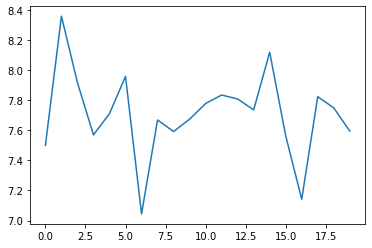

In [9]:
plt.plot(score_list[:20])

(20000.0, 30000.0)

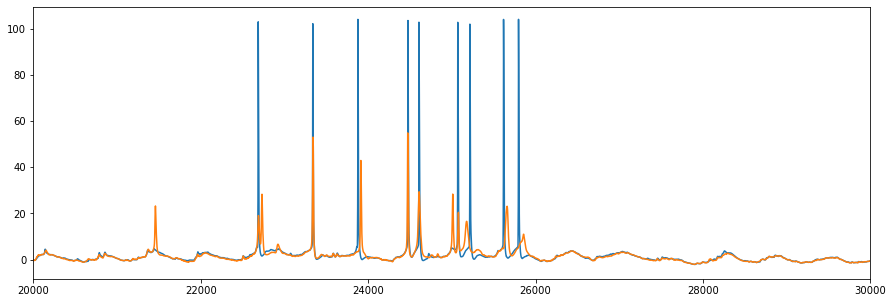

In [10]:
plt.figure(figsize=(15,5))
plt.plot(V_test.cpu().detach().numpy())
plt.plot(test_V_out.cpu().detach().numpy())

plt.xlim(20000,30000)

In [11]:
#torch.save(model_ap.state_dict(), "/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_l20_h40_0.2ms_V_joint.pt")
#torch.save(model_na.state_dict(), "/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_s5_h20_na_joint.pt")
#torch.save(model_nona.state_dict(), "/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_s5_h20_nona_joint.pt")


# Test

In [7]:
model_na.load_state_dict(torch.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_s5_h20_na_joint.pt",
                     map_location=device))
model_nona.load_state_dict(torch.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_s5_h20_nona_joint.pt",
                     map_location=device))
model_ap.load_state_dict(torch.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_l20_h40_0.2ms_V_joint.pt",
                     map_location=device))

model_na.eval()
model_nona.eval()
model_ap.eval()

AP_GRU_Lag(
  (rnn): GRU(21, 40, batch_first=True)
  (linear): Linear(in_features=40, out_features=1, bias=True)
)

In [10]:
V_test = V[980*50000:].reshape(20,50000)
test_V_out = np.empty((20,50000))
test_na_sub_out = np.empty((20,5,50000))
test_nona_sub_out = np.empty((20,5,50000))
batch_size = 5
for i in tnrange(20//batch_size):
    batch_E_neural = E_neural[980*50000 + i*batch_size*50000: 980*50000 + (i+1)*batch_size*50000].toarray().reshape(batch_size, 50000, 2000)
    batch_I_neural = I_neural[980*50000 + i*batch_size*50000: 980*50000 + (i+1)*batch_size*50000].toarray().reshape(batch_size, 50000, 200)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    
    batch_na, batch_na_sub = model_na(batch_E_neural, batch_I_neural)
    batch_nona, batch_nona_sub = model_nona(batch_E_neural, batch_I_neural)
    batch_soma = batch_na + batch_nona - soma_mean
    batch_soma_in = torch.zeros((batch_size, batch_length, lag+1)).to(device) #(lag,1000,50000)
    for j in range(lag):
        batch_soma_in[:,j+1:,j+1] = batch_soma_in[:,j+1:,j+1] + batch_soma[:,:-j-1]
    batch_soma_in[:,:,0] = batch_soma_in[:,:,0] + batch_soma 
    
    V_out = model_ap(batch_soma_in) + batch_soma
    test_V_out[i*batch_size:(i+1)*batch_size] = V_out.cpu().detach().numpy()
    test_na_sub_out[i*batch_size:(i+1)*batch_size] = np.transpose(batch_na_sub.cpu().detach().numpy(), [0,2,1])
    test_nona_sub_out[i*batch_size:(i+1)*batch_size] = np.transpose(batch_nona_sub.cpu().detach().numpy(), [0,2,1])

<ipython-input-10-a0e706c637c8>:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(20//batch_size):


  0%|          | 0/4 [00:00<?, ?it/s]

(23000.0, 27000.0)

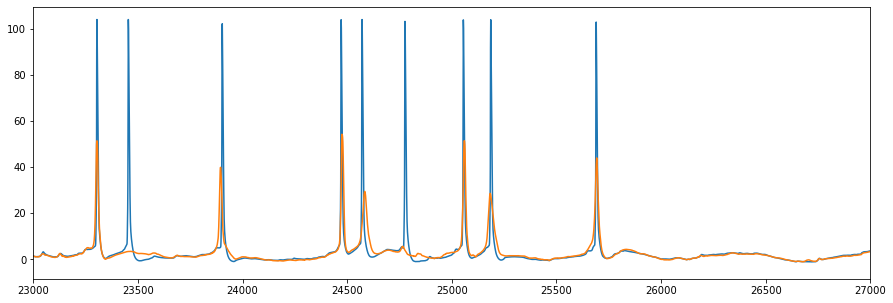

In [13]:
plt.figure(figsize=(15,5))
plt.plot(V_test[0])
plt.plot(test_V_out[0])
plt.xlim(23000,27000)

In [14]:

#np.savez("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_l20_h40_0.2ms_V_test_joint_output.npz",
        test=test_V_out,
        na_sub_out=test_na_sub_out,
         nona_sub_out=test_nona_sub_out)